In [161]:
import numpy as np
import os
import util as u
from MRI_layers_MK1 import *
import matplotlib.pyplot as plt
import pickle

In [162]:
base = "/Users/nathanielnethercott/Desktop/School/2021/Pickled_Sample/"
fpaths = [os.path.join(base,p) for p in os.listdir(base)]

In [163]:
test = pickle.load(open(fpaths[0], 'rb'))

In [164]:
def _find_layers(mask_data):
    l = []
    for i in range(mask_data.shape[-1]):
        if np.mean(mask_data[:,:,i])>0.0:
            l.append(i)
    return l

t1 = test[1]
t2 = test[2]

#only interested in scans with lesions
_masks = [t2[:,:,i] for i in _find_layers(t2)]
_scans = [t1[:,:,i] for i in _find_layers(t2)]

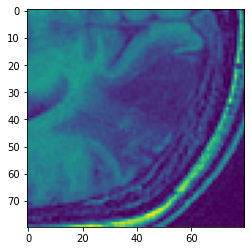

In [165]:
img = _scans[12]/255
mask = _masks[12]/255

subimg = img[120:200, 130:210]
submask = mask[120:200, 130:210]
plt.imshow(subimg)
#plt.contour(submask)

In [166]:
#try some pillow stuff 
from PIL import Image, ImageEnhance, ImageOps
from matplotlib import cm

#convert to pil image adding a color map?
pil_im = Image.fromarray(np.uint8(cm.gray(subimg)*255))
pil_im = ImageOps.grayscale(pil_im)

#enhancer
enhancer = ImageEnhance.Contrast(pil_im)

<ipython-input-167-712b42ed418e>:5: UserWarning: No contour levels were found within the data range.
  plt.contour(submask, [0], colors=['red'], linewidths=0.9)


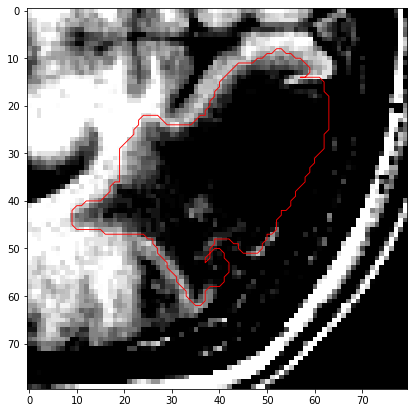

In [167]:
im = enhancer.enhance(8)

plt.figure(figsize=(7,7))
plt.imshow(im, cmap='gray')
plt.contour(submask, [0], colors=['red'], linewidths=0.9)

In [168]:
# need this...
def iteration(surface, image, dt=0.0001, alpha = 1, beta=1):
    d = lambda x,y: (x**2 + y**2)**0.5

    #absolutely do not forget to add this grid spacing in the function argument 
    sy, sx = np.gradient(surface, np.linspace(-1,1, surface.shape[0]), np.linspace(-1,1, surface.shape[1]))

    #write logic for the time evolution of the curves 
    #surface curvature 
    K = u.mean_curvature(surface)

    #now the evolution function:
    F1 = K
    F2 = (image-1.0)**2 - (image - np.zeros(image.shape))**2

    surface = surface - (beta*F2+alpha*F1)*d(sx,sy)*dt

    return surface

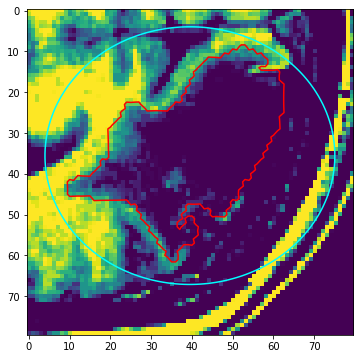

In [169]:
#try a segmentation functional with this now (we use code from scans2...)
c_subimg = np.array(im)
c_subimg = c_subimg/255

#first converge 
p = u.parabloid(subimg.shape, xrad=0.9, yrad=0.8, top=-0.1)
g = p

for i in range(3000):
    g = iteration(g, submask, dt = 0.001, beta=0.11, alpha=0.001)

plt.figure(figsize=(6,6))
plt.contour(g, [0], colors=['red'])
plt.contour(p, [0], colors=['cyan'])
plt.imshow(c_subimg)

In [170]:
#now lets check averages inside and out for contrasted image 
indeces = list(zip(*np.where(p>=0)))

#recall: g1 is the iterate 
_indeces = list(zip(*np.where(g>=0)))

i_out = 0
i_in = 0

#sum of intensities in original circle 
for i in indeces:
    i_out+=c_subimg[i[0],i[1]]

#subtract whats in the actual legion from circle and find legion net intensity 
for i in _indeces:
    i_out-=c_subimg[i[0],i[1]]
    i_in +=c_subimg[i[0],i[1]]
    
i_out = i_out/(len(indeces) - len(_indeces))
i_in = i_in/len(_indeces)
print(f'inside: {i_in}, outside: {i_out}')

inside: 0.0919296722378986, outside: 0.41449775692028423


In [171]:
#idea for time speed up: once professional identifies first lesion then crop future images 

#now lets see what happens when we use the new segmentation with the values determined above
def _iteration(surface, image, dt=0.0001, alpha = 1, beta=1):
    d = lambda x,y: (x**2 + y**2)**0.5

    #absolutely do not forget to add this grid spacing in the function argument 
    sy, sx = np.gradient(surface, np.linspace(-1,1, surface.shape[0]), np.linspace(-1,1, surface.shape[1]))

    #write logic for the time evolution of the curves 
    #surface curvature 
    K = u.mean_curvature(surface)

    #now the evolution function:
    F1 = K
    #segmentation
    F2 = (image-0.091929)**2 - (image - 0.414497)**2

    surface = surface - (beta*F2+alpha*F1)*d(sx,sy)*dt

    return surface

<ipython-input-172-57f0968512d8>:9: UserWarning: No contour levels were found within the data range.
  plt.contour(subnextmask, [0])
<ipython-input-172-57f0968512d8>:10: UserWarning: No contour levels were found within the data range.
  plt.contour(submask, [0])


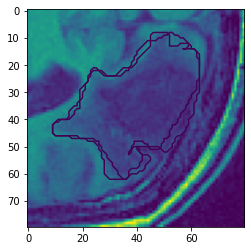

In [172]:
#let's take a look at the next image in the scans... not next but a few images up (so its sufficiently different)
nextimg = _scans[15]/255
nextmask = _masks[15]/255

subnextimg = nextimg[120:200, 130:210]
subnextmask = nextmask[120:200, 130:210]

plt.imshow(subnextimg)
plt.contour(subnextmask, [0])
plt.contour(submask, [0])

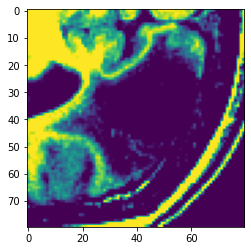

In [173]:
#apply preprocessing 
#Note: values used in seg functional dependent on constrast factor 
def preprocess(im_array, cfactor=8):
    """
    assume data isn't normalized 
    we convert to grayscale 
    we constrast 
    """
    pil_im = Image.fromarray(np.uint8(cm.gray(im_array)*255))
    pil_im = ImageOps.grayscale(pil_im)
    
    #enhancer 
    enhancer = ImageEnhance.Contrast(pil_im)
    im = enhancer.enhance(cfactor)
    
    return np.array(im)/255
    

#contrast
c_next = preprocess(subnextimg)
plt.imshow(c_next)

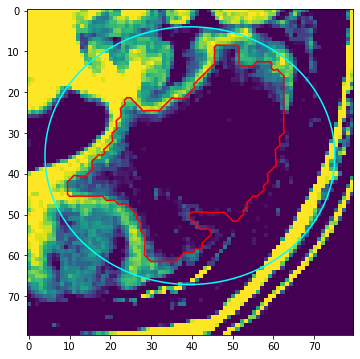

In [174]:
#now lets check some stuff quick to make sure values in and out are viable choices 

#generate a neighborhood 
p1 = u.parabloid(subimg.shape, xrad=0.9, yrad=0.8, top=-0.1)
#first converge 
g1 = g

for i in range(1200):
    g1 = iteration(g1, subnextmask, dt = 0.001, beta=0.11, alpha=0.001)

plt.figure(figsize=(6,6))
plt.contour(g1, [0], colors=['red'])
plt.imshow(c_next)
plt.contour(p, [0], colors=['cyan'])

In [175]:
#now find some interior/exterior vals 
#now lets check averages inside and out for contrasted image 
indeces = list(zip(*np.where(p1>=0)))

#recall: g1 is the iterate 
_indeces = list(zip(*np.where(g1>=0)))

i_out = 0
i_in = 0

#sum of intensities in original circle 
for i in indeces:
    i_out+=c_next[i[0],i[1]]

#subtract whats in the actual legion from circle and find legion net intensity 
for i in _indeces:
    i_out-=c_next[i[0],i[1]]
    i_in +=c_next[i[0],i[1]]
    
i_out = i_out/(len(indeces) - len(_indeces))
i_in = i_in/len(_indeces)
print(f'inside: {i_in}, outside: {i_out}')

inside: 0.08145239404172987, outside: 0.3785025688391163


<ipython-input-176-18a8c2a8042b>:11: UserWarning: No contour levels were found within the data range.
  plt.contour(subnextmask, [0], colors=['cyan'])
<ipython-input-176-18a8c2a8042b>:12: UserWarning: No contour levels were found within the data range.
  plt.contour(submask, [0], colors=['magenta'])


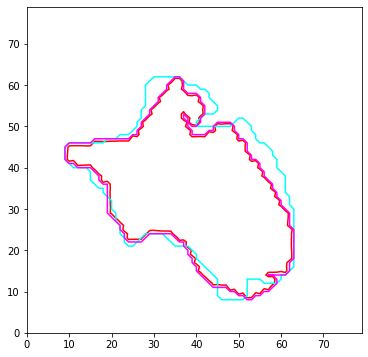

In [176]:
#okay now lets do the thing 
g11 = g

for i in range(1000):
    g11 = _iteration(g11, c_next, dt = 0.0002, beta=0.15, alpha=-0.0001)

plt.figure(figsize=(6,6))
plt.contour(g11, [0], colors=['red'])
#plt.contour(p, [0], colors=['cyan'])
#plt.imshow(c_next)
plt.contour(subnextmask, [0], colors=['cyan'])
plt.contour(submask, [0], colors=['magenta'])

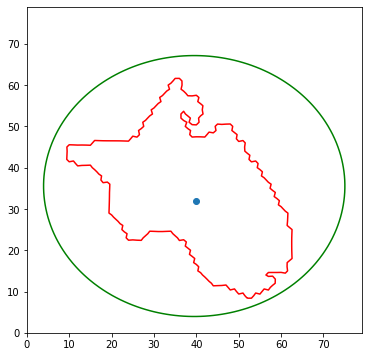

In [180]:
#goal is to somehow make an intermediary between these shapes 
plt.figure(figsize=(6,6))
plt.contour(g, [0], colors='red')
plt.contour(p, [0], colors='green')

#COM (roughly)
plt.plot([40],[32],'o')

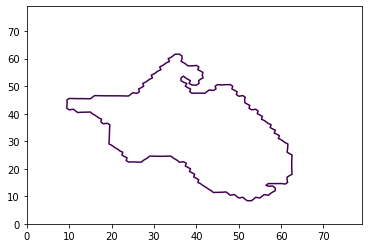

In [196]:
#how can i easily take a contour and stretch it radially outwards?
#lets try this...

#first get indeces (annoying cause it plots the contour but whatever)
cs = plt.contour(g, [0])
paths = cs.collections[0].get_paths()[0]
v = paths.vertices

#now stretch 
com = np.array([40,32])
new_v = []
for pair in v:
    new_v.append(com+1.25*(pair-com))
    

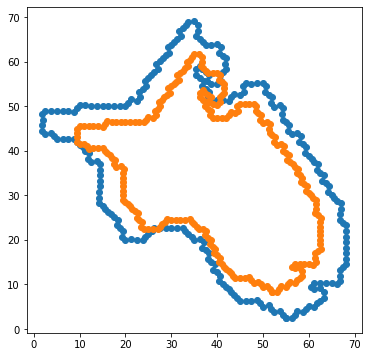

In [197]:
#scatter this
new_vt = np.transpose(new_v)
plt.figure(figsize=(6,6))
#new
plt.scatter(new_vt[0], new_vt[1])
#original
vt = np.transpose(v)
plt.scatter(vt[0], vt[1])

#okay that's dece enough 
#but wait how does this apply to the surface???